<a href="https://colab.research.google.com/github/guptaru1/StockPrediction/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


try:
    import yahoo_fin.stock_info as si
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        !pip install yahoo_fin
    import yahoo_fin.stock_info as si
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
mutation_prob = 0.2
crossover_prob = 0.8
initial_population = 100
generations = 150
rsi_threshold = 30
ema_weight = 0.8


def pre_process(stock_data):
  data = stock_data[["close"]]
  data = data.rename(columns= {'close': 'actualclose'})
  #this is so that we can see which is higer or above in the stock
  #data["Target"] = stock_data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Actual_Close"]
  data['Target'] = (data['actualclose'] > data['actualclose'].shift(1)).astype(int)
  stock_data_copy = stock_data.copy()
  stock_data_shifted = stock_data_copy.shift(1)

  #combine training data
  predictors = ["close", "volume", "open", "high", "low"]
  data = data.join(stock_data_shifted[predictors]).iloc[1:]

  return data


#calculate simple moving average using %d which is usually a 3 day period
def calculate_stochastic_oscillator(data, k_period=14, d_period=3):
    # Calculate %K
    data['Lowest Low'] = data['low'].rolling(window=k_period).min()
    data['Highest High'] = data['high'].rolling(window=k_period).max()
    data['%K'] = ((data['close'] - data['Lowest Low']) / (data['Highest High'] - data['Lowest Low'])) * 100
    # Calculate %D (3-period SMA of %K)
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    # Drop auxiliary columns
    data.drop(['Lowest Low', 'Highest High'], axis=1, inplace=True)
    return data[['%K', '%D']]


def calculate_features(data):
    close_prices = data['close']
    #rsi
    #rsi = talib.RSI(close_prices, timeperiod=14)
    #calcualte ema
    #sma for a 200 period
    data["200day"] = data["close"].rolling(200).mean()

    #sma for a 50 day period
    data["50day"] = data["close"].rolling(50).mean()
    print("new features")
    print(data.head(5))



def sharpe_ratio(weights, data):
  data_returns = np.log(data) - np.log(data.shift(1))
  data_returns = data_returns.dropna()

  portfolio_returns = np.dot(data_returns, weights)
  portfolio_mean = np.mean(portfolio_returns)
  portfolio_std = np.std(portfolio_returns)
  sharpe_ratio = (portfolio_mean / portfolio_std) * np.sqrt(252)
  return sharpe_ratio


# Scrape stock data from Yahoo Finance

stock_data = si.get_data("AAPL")
'''
stock_data = si.download('AAPL',
                      start='2010-01-01',
                      end='2021-06-12',
                      progress=False,
)
'''


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.1 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=a322f1944b37e81652d7778b49babe1bcdbffb1999c7ef66172a8299dcf6cbe5
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=212db735473b80a54a0cbd50b579b56d5b8cb74de6e518154ec52c78aef3a2ce
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built bs4 sgmllib3k
  Attempting uninstall: urllib3
    Found exist

"\nstock_data = si.download('AAPL',\n                      start='2010-01-01',\n                      end='2021-06-12',\n                      progress=False,\n)\n"

In [ ]:
#calculate simple moving average using %d which is usually a 3 day period
from datetime import datetime, timedelta

def calculate_stochastic_oscillator(data, k_period=14, d_period=3):
    # Calculate %K
    data['Lowest Low'] = data['low'].rolling(window=k_period).min()
    data['Highest High'] = data['high'].rolling(window=k_period).max()
    data['%K'] = ((data['close'] - data['Lowest Low']) / (data['Highest High'] - data['Lowest Low'])) * 100
    # Calculate %D (3-period SMA of %K)
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    # Drop auxiliary columns
    data.drop(['Lowest Low', 'Highest High'], axis=1, inplace=True)
    return data[['%K', '%D']]


def esa(data):
    close_prices = data['close']
    #rsi
    #rsi = talib.RSI(close_prices, timeperiod=14)
    #calcualte ema
    #sma for a 200 period
    data["200day"] = data["close"].rolling(200).mean()
    #sma for a 50 day period
    data["50day"] = data["close"].rolling(50).mean()
    data["26day"] = data["close"].rolling(26).mean()
    data["12day"] = data["close"].rolling(12).mean()
    data['dif'] = data['12day'] - data['26day']
    columns_to_drop = ["26day", "12day"]

    # Calculate the rolling mean (middle band)
    # Drop the specified columns
    data.drop(columns=columns_to_drop, inplace=True)

def boilinger_band(data, window=20):
    # Calculate the rolling mean and standard deviation
    rolling_mean = data['close'].rolling(window=window).mean()
    rolling_std = data['close'].rolling(window=window).std()

    # Calculate upper and lower bands
    data["upper_band"] = rolling_mean + (rolling_std * num_std)
    data["lower_band"] = rolling_mean - (rolling_std * num_std)


def calculate_ichimoku_cloud(data, tenkan_period=9, kijun_period=26, senkou_span_b_period=52, displacement=26):
    # Calculate Tenkan-sen
    data['Tenkan-sen'] = (data['high'].rolling(window=tenkan_period).max() + data['low'].rolling(window=tenkan_period).min()) / 2

    # Calculate Kijun-sen
    data['Kijun-sen'] = (data['high'].rolling(window=kijun_period).max() + data['low'].rolling(window=kijun_period).min()) / 2

    # Calculate Senkou Span A
    data['Senkou Span A'] = ((data['Tenkan-sen'] + data['Kijun-sen']) / 2).shift(displacement)

    # Calculate Senkou Span B
    data['Senkou Span B'] = ((data['high'].rolling(window=senkou_span_b_period).max() + data['low'].rolling(window=senkou_span_b_period).min()) / 2).shift(displacement)


def cal_fsl_udl(data):
  data['price_change'] = data['close'].diff()

  # Calculate Upside and Downside Volumes
  data['upside_volume'] = data['volume'].where(data['price_change'] > 0, 0)
  data['downside_volume'] = data['volume'].where(data['price_change'] < 0, 0)

  # Calculate Upside Downside Line (UDL)
  data['udl'] = data['upside_volume'].cumsum() - data['downside_volume'].cumsum()

  # Calculate Force Index (FSL)
  data['fsl'] = data['price_change'] * data['volume']

  columns_to_drop = ["price_change" , "upside_volume", "downside_volume"]
  data.drop(columns = columns_to_drop, inplace=True)


def calculate_rsi(data, period=14):
    # Calculate price changes
    delta = data['close'].diff(1)

    # Calculate gain (positive price changes) and loss (negative price changes)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate average gain and average loss over the specified period
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    # Calculate relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    data["rsi"] = rsi

def accumulate_distribution(df):
    df['A/D'] = (df['close'] - df['low'] - (df['high'] - df['close'])) / (df['high'] - df['low']) * df['volume']
    df['A/D'] = df['A/D'].cumsum()  # Cumulative sum to get the Accumulation/Distribution line


def CCI(df):
  # Calculate Typical Price (TP)
  df['TP'] = (df['high'] + df['low'] + df['close']) / 3
  # Calculate 10-period Simple Moving Average (SMA) of Typical Prices
  df['SMA10'] = df['TP'].rolling(window=10).mean()
  # Calculate Mean Deviation (MD)
  df['MD'] = df['TP'] - df['SMA10']
  df['MD'] = df['MD'].abs().rolling(window=10).sum()
  # Calculate Commodity Channel Index (CCI)
  factor = 0.015
  df['CCI'] = (df['TP'] - df['SMA10']) / (factor * df['MD'])
  # Drop intermediate columns (TP, SMA10, MD)
  df.drop(['TP', 'SMA10', 'MD'], axis=1, inplace=True)


def sharpe_ratio(weights, data):
  data_returns = np.log(data) - np.log(data.shift(1))
  data_returns = data_returns.dropna()

  portfolio_returns = np.dot(data_returns, weights)
  portfolio_mean = np.mean(portfolio_returns)
  portfolio_std = np.std(portfolio_returns)
  sharpe_ratio = (portfolio_mean / portfolio_std) * np.sqrt(252)
  return sharpe_ratio


def calculate_features(processed_data, feature_functions):
  for func in feature_functions:
        func(processed_data)
  return processed_data

def calculate_adx(data, period=14):
    # Calculate True Range (TR)
    data['High-Low'] = data['high'] - data['low']
    data['High-PrevClose'] = abs(data['high'] - data['close'].shift(1))
    data['Low-PrevClose'] = abs(data['low'] - data['close'].shift(1))
    data['TR'] = data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

    # Calculate +DM and -DM
    data['UpMove'] = data['high'].diff()
    data['DownMove'] = -data['low'].diff()
    data['+DM'] = data['UpMove'].where((data['UpMove'] > data['DownMove']) & (data['UpMove'] > 0), 0)
    data['-DM'] = data['DownMove'].where((data['DownMove'] > data['UpMove']) & (data['DownMove'] > 0), 0)

    # Smoothed TR, +DM, and -DM
    data['ATR'] = data['TR'].ewm(span=period, adjust=False).mean()
    data['+DM_Smoothed'] = data['+DM'].ewm(span=period, adjust=False).mean()
    data['-DM_Smoothed'] = data['-DM'].ewm(span=period, adjust=False).mean()

    # Calculate +DI and -DI
    data['+DI'] = (data['+DM_Smoothed'] / data['ATR']) * 100
    data['-DI'] = (data['-DM_Smoothed'] / data['ATR']) * 100

    # Calculate DX
    data['DX'] = (abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI'])) * 100

    # Calculate ADX
    data['ADX'] = data['DX'].ewm(span=period, adjust=False).mean()

    # Drop intermediate columns
    data.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'UpMove', 'DownMove', '+DM', '-DM', 'ATR', '+DM_Smoothed', '-DM_Smoothed', '+DI', '-DI', 'DX'], axis=1, inplace=True)


processed_data = pre_process(stock_data)
feature_functions = [esa, calculate_stochastic_oscillator, calculate_rsi, CCI, accumulate_distribution, cal_fsl_udl, calculate_ichimoku_cloud, calculate_adx]
processed_data = calculate_features(processed_data, feature_functions)
#calculate_features(processed_data)
print("new features")
processed_data  = processed_data.dropna()
#getting data to train from 1982-12-06 till 2023-11-29
X_selected = processed_data.iloc[300:]
print(X_selected.tail())
print(processed_data.head())

new features
            actualclose  Target       close      volume        open  \
2023-11-24   189.970001       0  191.309998  39617700.0  191.490005   
2023-11-27   189.789993       0  189.970001  24048300.0  190.869995   
2023-11-28   190.399994       1  189.789993  40552600.0  189.919998   
2023-11-29   189.369995       0  190.399994  38415400.0  189.779999   
2023-11-30   188.720001       0  189.369995  43014200.0  190.899994   

                  high         low     200day       50day       dif  ...  \
2023-11-24  192.929993  190.830002  174.14445  177.781401  7.526474  ...   
2023-11-27  190.899994  189.250000  174.33470  178.066001  7.662179  ...   
2023-11-28  190.669998  188.899994  174.52930  178.361601  7.686025  ...   
2023-11-29  191.080002  189.399994  174.72625  178.610201  7.678012  ...   
2023-11-30  192.089996  188.970001  174.90385  178.816201  7.295896  ...   

                 CCI           A/D           udl           fsl  Tenkan-sen  \
2023-11-24  4.206153  4.5

In [ ]:
#implement the genetic algorithm
try:
  from sklearn.model_selection import train_test_split
except:
  !pip install -U scikit-learn
  from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import random
import warnings
from tqdm import tqdm
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense




# Filter out the specific UserWarning from scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.base")



class Chromosome():
  def __init__(self, num_features, gene):

      print("Generated genes:", gene)
      #np array
      self.genes = gene



class Population():
  def __init__(self, population_size,dataset, num_features =15 ):
      #generates our initial population -> rep of 1,0 for what feature to include and what not to
      self.population = []
      self.features = dataset[["200day", "50day", "rsi", "%K", "%D", "CCI", "A/D", "udl", "fsl", "TR", "ADX", "Tenkan-sen", "Kijun-sen", "Senkou Span A", "Senkou Span B"]]
      self.target_vals = dataset["Target"]

      self.max_fitness = 0
      self.num_features = num_features
      self.best_solution = None
      self.population_size = population_size
      self.gene_length = num_features
      self.init_pop()


  #generate init population
  def init_pop(self):
      seed_counter = 0
      for i in range(self.population_size):
            # Use a unique seed for each chromosome
            seed = int(time.time()) + seed_counter
            np.random.seed(seed)

            self.population.append(Chromosome(self.num_features, np.random.randint(2, size=self.num_features)))

            # Increment the counter for the next chromosome
            seed_counter += 1

  def lstm_model(self, dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    time_steps = 20

    sequences, labels = [], []
    for i in range(len(scaled_data) - time_steps):
      sequences.append(scaled_data[i: i + time_steps, :])
      labels.append(self.target_vals[i+time_steps, :])

    X, y = np.array(sequences), np.array(labels)
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=None)

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data= (X_test,y_test))
    loss = model.evaluate(X_test, y_test)
    print(f'LOSS VALUE {loss}')

    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("my LSTM accuracy", accuracy)
  def evaluate_fitness(self, chromosome):
        # Create a simple dataset for demonstration purposes
        X, y = self.features, self.target_vals
        y = y.iloc[300:]
        print("My chromosome value", chromosome.genes)
        # Select features based on the chromosome
        selected_features = [i for i in range(self.num_features) if chromosome.genes[i] == 1]
        if not selected_features:
            return 0
        X_selected = X.iloc[300:, selected_features]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=None)
        #print("MY TRAINING DATA", X_train.values)
        # Train a model and evaluate accuracy
        model = RandomForestClassifier()
        model.fit(X_train.values, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        print("my accuracy", accuracy)
        mse = mean_squared_error(y_test, y_pred)
        return 1 / mse


  def mutation(self, individual, mutation_prob = 0.2, start_range=0):
       # if individual.genes[1] > individual.genes[0]:
         # individual.genes[0] =
        random_number = random.randint(6000, 10000)
        rsi_sma_psi = processed_data.iloc[random_number]
        #indicate the same direction
        if rsi_sma_psi["rsi"] > 70 and rsi_sma_psi["50day"] < rsi_sma_psi["200day"] or rsi_sma_psi["rsi"] < 30 and rsi_sma_psi["50day"] > rsi_sma_psi["200day"] :
          #keep the three features
          start_range = 3
        for i in range(start_range,self.gene_length):
            if random.random() < mutation_prob:
                individual.genes[i] = 1 - individual.genes[i]

  def chromosome(self, parent1, parent2):
    crossover_point = random.randint(1, min(len(parent1.genes), len(parent2.genes)) - 1)
    #check if rsi and msad show the same direction for stock price prediction then keep them in the final solution
    #rsi_sma_p1 = True if self.features.iloc["rsi"] >  70 and parent1.genes[1] < parent1.genes[0] else False
   # rsi_sma_p2
    print("The two paernt", parent1, parent2)
    print("New child chromosme 1", parent1.genes[:crossover_point])
    print("New child chromosome 2", parent2.genes[crossover_point:])
    child_chromosome = np.concatenate((parent1.genes[:crossover_point], parent2.genes[crossover_point:]))
    new_child = Chromosome(4, child_chromosome)
    return new_child


  def evolve(self, generations=50, elitisim_size = 10):
    losses = []
    for generation in tqdm(range(generations), desc="Generations"):
      fitness_scores = [self.evaluate_fitness(chrom) for chrom in self.population]
      best_index = np.argmin(fitness_scores)
      best_chromosome = self.population[best_index]
      best_fitness_val = fitness_scores[best_index]
      losses.append(best_fitness_val)
      print(f"generation {generation}")
      if best_fitness_val > self.max_fitness:
        #update crossover to use what features gave the best fitness and keep those binary digists fixed anad change other parts or do this for mutation as well
        self.max_fitness = best_fitness_val
        self.best_solution = best_chromosome
        print(f"Generation {generation+1}: Best Fitness = {best_fitness_val}")

      elite_population = sorted(self.population, key=lambda x: self.evaluate_fitness(x), reverse=True)[:elitisim_size]

            # Genetic operations: Crossover and Mutation
      new_population = elite_population.copy()
      for _ in range((self.population_size - elitisim_size) // 2):
                print("testing this loop")
                parent1, parent2 = random.sample(elite_population, 2)
                child1 = self.chromosome(parent1, parent2)
                child2 = self.chromosome(parent2, parent1)

                self.mutation(child1)
                self.mutation(child2)

                new_population.extend([child1, child2])

      self.population = new_population
    return losses

if __name__ == "__main__":
    pop = Population(population_size=15, num_features=15, dataset=processed_data)
    losses = pop.evolve(generations=20)

    # Plot the error minimization curve
    #plt.plot(range(1, (50) + 1), losses)
    #plt.title('Genetic Algorithm - Error Minimization Curve')
    #plt.xlabel('Generation')
    #plt.ylabel('Best Fitness Value')
   # plt.show()

Generated genes: [0 0 1 1 0 0 0 1 0 0 1 1 0 0 0]
Generated genes: [1 1 0 0 0 0 1 1 0 0 0 0 1 1 0]
Generated genes: [0 1 1 1 1 1 1 1 0 1 0 0 0 0 1]
Generated genes: [1 1 1 1 0 0 0 1 0 0 0 1 1 0 1]
Generated genes: [1 0 0 0 1 1 0 0 0 0 1 0 0 0 1]
Generated genes: [0 1 0 0 0 1 0 1 0 0 0 0 0 0 1]
Generated genes: [1 1 0 1 1 1 1 0 1 1 0 1 1 0 0]
Generated genes: [1 0 1 0 1 0 0 0 1 1 1 1 1 1 1]
Generated genes: [0 1 0 1 0 0 1 1 1 1 0 0 0 0 1]
Generated genes: [1 0 0 0 0 0 1 1 1 1 0 0 1 0 1]
Generated genes: [0 0 1 1 0 1 0 1 0 1 0 1 1 1 1]
Generated genes: [0 1 0 1 0 0 0 1 0 1 0 1 1 0 0]
Generated genes: [0 1 1 1 1 0 1 0 1 0 1 1 1 0 0]
Generated genes: [0 0 1 1 0 1 1 1 1 0 1 1 1 1 0]
Generated genes: [0 1 1 1 1 0 0 1 1 0 1 1 1 0 0]


Generations:   0%|          | 0/20 [00:00<?, ?it/s]

My chromosome value [0 0 1 1 0 0 0 1 0 0 1 1 0 0 0]
my accuracy 0.511639185257032
My chromosome value [1 1 0 0 0 0 1 1 0 0 0 0 1 1 0]
my accuracy 0.5640155189136761
My chromosome value [0 1 1 1 1 1 1 1 0 1 0 0 0 0 1]
my accuracy 0.5339476236663434
My chromosome value [1 1 1 1 0 0 0 1 0 0 0 1 1 0 1]
my accuracy 0.5281280310378274
My chromosome value [1 0 0 0 1 1 0 0 0 0 1 0 0 0 1]
my accuracy 0.5198836081474297
My chromosome value [0 1 0 0 0 1 0 1 0 0 0 0 0 0 1]
my accuracy 0.5324927255092143
My chromosome value [1 1 0 1 1 1 1 0 1 1 0 1 1 0 0]
my accuracy 0.5155189136760426
My chromosome value [1 0 1 0 1 0 0 0 1 1 1 1 1 1 1]
my accuracy 0.5004849660523764
My chromosome value [0 1 0 1 0 0 1 1 1 1 0 0 0 0 1]
my accuracy 0.5242483026188167
My chromosome value [1 0 0 0 0 0 1 1 1 1 0 0 1 0 1]
my accuracy 0.5155189136760426
My chromosome value [0 0 1 1 0 1 0 1 0 1 0 1 1 1 1]
my accuracy 0.5227934044616876
My chromosome value [0 1 0 1 0 0 0 1 0 1 0 1 1 0 0]
my accuracy 0.5126091173617847
My ch

Generations:   5%|▌         | 1/20 [02:32<48:22, 152.76s/it]

my accuracy 0.5
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485fbe0> <__main__.Chromosome object at 0x79d46485f970>
New child chromosme 1 [0 1 0 1 0 0 0 1]
New child chromosome 2 [0 1 0 1 1 1 1]
Generated genes: [0 1 0 1 0 0 0 1 0 1 0 1 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d46485f970> <__main__.Chromosome object at 0x79d46485fbe0>
New child chromosme 1 [0 0 1 1 0 1 0 1 0 1 0 1]
New child chromosome 2 [1 0 0]
Generated genes: [0 0 1 1 0 1 0 1 0 1 0 1 1 0 0]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46470f1c0> <__main__.Chromosome object at 0x79d46485ff10>
New child chromosme 1 [1 1 1 1 0 0]
New child chromosome 2 [1 1 1 0 1 1 1 1 0]
Generated genes: [1 1 1 1 0 0 1 1 1 0 1 1 1 1 0]
The two paernt <__main__.Chromosome object at 0x79d46485ff10> <__main__.Chromosome object at 0x79d46470f1c0>
New child chromosme 1 [0 0]
New child chromosome 2 [1 1 0 0 0 1 0 0 0 1 1 0 1]
Generated genes: [0 0 1 1 0 0 0 1 0 0 0 1 1 0 1]


Generations:  10%|█         | 2/20 [04:18<37:28, 124.94s/it]

my accuracy 0.4980601357904947
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46470f1c0> <__main__.Chromosome object at 0x79d46470e7d0>
New child chromosme 1 [1]
New child chromosome 2 [1 0 0 0 1 0 1 0 0 0 0 0 0 1]
Generated genes: [1 1 0 0 0 1 0 1 0 0 0 0 0 0 1]
The two paernt <__main__.Chromosome object at 0x79d46470e7d0> <__main__.Chromosome object at 0x79d46470f1c0>
New child chromosme 1 [0 1]
New child chromosome 2 [1 1 0 0 0 1 0 0 0 1 1 0 1]
Generated genes: [0 1 1 1 0 0 0 1 0 0 0 1 1 0 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46470fb50> <__main__.Chromosome object at 0x79d46470f3a0>
New child chromosme 1 [1 1 0 0 0 0 1 1 0 0 0 0 1 1]
New child chromosome 2 [1]
Generated genes: [1 1 0 0 0 0 1 1 0 0 0 0 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d46470f3a0> <__main__.Chromosome object at 0x79d46470fb50>
New child chromosme 1 [0 1 1]
New child chromosome 2 [0 0 0 1 1 0 0 0 0 1 1 0]
Generated genes: [0 1 1 0 0 0 1 1 

Generations:  15%|█▌        | 3/20 [06:06<33:11, 117.15s/it]

my accuracy 0.537827352085354
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46470e7d0> <__main__.Chromosome object at 0x79d46470fb50>
New child chromosme 1 [0 1 0 0 0 1 0 1 0]
New child chromosome 2 [0 0 0 1 1 0]
Generated genes: [0 1 0 0 0 1 0 1 0 0 0 0 1 1 0]
The two paernt <__main__.Chromosome object at 0x79d46470fb50> <__main__.Chromosome object at 0x79d46470e7d0>
New child chromosme 1 [1 1 0 0 0 0 1 1 0 0 0 0 1 1]
New child chromosome 2 [1]
Generated genes: [1 1 0 0 0 0 1 1 0 0 0 0 1 1 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485ff10> <__main__.Chromosome object at 0x79d46485ce80>
New child chromosme 1 [0 0 1 1 0 1 1 1 1]
New child chromosome 2 [0 0 0 1 1 1]
Generated genes: [0 0 1 1 0 1 1 1 1 0 0 0 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d46485ce80> <__main__.Chromosome object at 0x79d46485ff10>
New child chromosme 1 [1 1 1 0]
New child chromosome 2 [0 1 1 1 1 0 1 1 1 1 0]
Generated genes: [1 1 1 0 0 1 1 1 1

Generations:  20%|██        | 4/20 [07:50<29:51, 111.96s/it]

my accuracy 0.501454898157129
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485fd90> <__main__.Chromosome object at 0x79d46470f1c0>
New child chromosme 1 [0 1 1]
New child chromosome 2 [1 0 0 0 1 0 0 0 1 1 0 1]
Generated genes: [0 1 1 1 0 0 0 1 0 0 0 1 1 0 1]
The two paernt <__main__.Chromosome object at 0x79d46470f1c0> <__main__.Chromosome object at 0x79d46485fd90>
New child chromosme 1 [1 1 1 1 0 0 0 1 0]
New child chromosome 2 [0 1 1 1 0 0]
Generated genes: [1 1 1 1 0 0 0 1 0 0 1 1 1 0 0]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46470fb50> <__main__.Chromosome object at 0x79d4648b3d60>
New child chromosme 1 [1 1 0 0 0]
New child chromosome 2 [0 0 1 0 0 0 1 1 0 1]
Generated genes: [1 1 0 0 0 0 0 1 0 0 0 1 1 0 1]
The two paernt <__main__.Chromosome object at 0x79d4648b3d60> <__main__.Chromosome object at 0x79d46470fb50>
New child chromosme 1 [0 1 1 1 0 0 0 1]
New child chromosome 2 [0 0 0 0 1 1 0]
Generated genes: [0 1 1 1 0 0 0 1 0

Generations:  25%|██▌       | 5/20 [10:18<31:16, 125.10s/it]

my accuracy 0.5174587778855481
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46470f1c0> <__main__.Chromosome object at 0x79d46485ce80>
New child chromosme 1 [1 1 1 1 0 0 0 1 0 0 0]
New child chromosome 2 [0 1 1 1]
Generated genes: [1 1 1 1 0 0 0 1 0 0 0 0 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d46485ce80> <__main__.Chromosome object at 0x79d46470f1c0>
New child chromosme 1 [1 1 1 0 1 1]
New child chromosome 2 [0 1 0 0 0 1 1 0 1]
Generated genes: [1 1 1 0 1 1 0 1 0 0 0 1 1 0 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485ce80> <__main__.Chromosome object at 0x79d46485fb80>
New child chromosme 1 [1 1 1 0 1 1 0]
New child chromosome 2 [1 0 1 1 1 1 1 0]
Generated genes: [1 1 1 0 1 1 0 1 0 1 1 1 1 1 0]
The two paernt <__main__.Chromosome object at 0x79d46485fb80> <__main__.Chromosome object at 0x79d46485ce80>
New child chromosme 1 [0 1 0 0 0 0 1]
New child chromosome 2 [1 0 0 0 0 1 1 1]
Generated genes: [0 1 0 0 0 0 1 1 

Generations:  30%|███       | 6/20 [12:13<28:23, 121.67s/it]

my accuracy 0.5257032007759457
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4648b3d60> <__main__.Chromosome object at 0x79d46485f9d0>
New child chromosme 1 [0 1 1 1 0]
New child chromosome 2 [0 0 1 0 0 1 0 1 1 1]
Generated genes: [0 1 1 1 0 0 0 1 0 0 1 0 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d46485f9d0> <__main__.Chromosome object at 0x79d4648b3d60>
New child chromosme 1 [1 1 0 1 0]
New child chromosome 2 [0 0 1 0 0 0 1 1 0 1]
Generated genes: [1 1 0 1 0 0 0 1 0 0 0 1 1 0 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4648b3d60> <__main__.Chromosome object at 0x79d46470f3a0>
New child chromosme 1 [0 1 1 1 0 0 0 1 0]
New child chromosome 2 [1 0 0 0 0 1]
Generated genes: [0 1 1 1 0 0 0 1 0 1 0 0 0 0 1]
The two paernt <__main__.Chromosome object at 0x79d46470f3a0> <__main__.Chromosome object at 0x79d4648b3d60>
New child chromosme 1 [0 1 1]
New child chromosome 2 [1 0 0 0 1 0 0 0 1 1 0 1]
Generated genes: [0 1 1 1 0 0 0 1 

Generations:  35%|███▌      | 7/20 [14:01<25:23, 117.22s/it]

my accuracy 0.501454898157129
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485d4e0> <__main__.Chromosome object at 0x79d46485e920>
New child chromosme 1 [1]
New child chromosome 2 [1 0 1 1 0 0 1 0 0 0 1 1 1 1]
Generated genes: [1 1 0 1 1 0 0 1 0 0 0 1 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d46485e920> <__main__.Chromosome object at 0x79d46485d4e0>
New child chromosme 1 [1 1 0 1 1 0 0 1 0 0 0 1]
New child chromosome 2 [1 1 0]
Generated genes: [1 1 0 1 1 0 0 1 0 0 0 1 1 1 0]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485ce80> <__main__.Chromosome object at 0x79d4648b3d60>
New child chromosme 1 [1 1]
New child chromosome 2 [1 1 0 0 0 1 0 0 0 1 1 0 1]
Generated genes: [1 1 1 1 0 0 0 1 0 0 0 1 1 0 1]
The two paernt <__main__.Chromosome object at 0x79d4648b3d60> <__main__.Chromosome object at 0x79d46485ce80>
New child chromosme 1 [0 1 1 1 0 0 0 1 0 0 0 1 1 0]
New child chromosome 2 [1]
Generated genes: [0 1 1 1 0 0 0 1 0

Generations:  40%|████      | 8/20 [15:49<22:49, 114.12s/it]

my accuracy 0.5208535402521823
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485e380> <__main__.Chromosome object at 0x79d4b0ddd7b0>
New child chromosme 1 [0 1 0 1 0]
New child chromosome 2 [0 0 1 0 0 1 1 1 1 1]
Generated genes: [0 1 0 1 0 0 0 1 0 0 1 1 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d4b0ddd7b0> <__main__.Chromosome object at 0x79d46485e380>
New child chromosme 1 [1 1 0 1 0 0 0 1 0 0 1 1 1]
New child chromosome 2 [0 1]
Generated genes: [1 1 0 1 0 0 0 1 0 0 1 1 1 0 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485ce80> <__main__.Chromosome object at 0x79d46485d5a0>
New child chromosme 1 [1 1 1]
New child chromosome 2 [1 0 0 1 1 0 0 0 0 1 1 1]
Generated genes: [1 1 1 1 0 0 1 1 0 0 0 0 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d46485d5a0> <__main__.Chromosome object at 0x79d46485ce80>
New child chromosme 1 [1 1 0 1 0]
New child chromosome 2 [1 0 1 0 0 0 0 1 1 1]
Generated genes: [1 1 0 1 0 1 0 1 

Generations:  45%|████▌     | 9/20 [17:33<20:23, 111.23s/it]

my accuracy 0.5237633365664404
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485d5a0> <__main__.Chromosome object at 0x79d46470d6f0>
New child chromosme 1 [1 1 0 1 0 0 1 1 0 0 0 0 1]
New child chromosome 2 [1 0]
Generated genes: [1 1 0 1 0 0 1 1 0 0 0 0 1 1 0]
The two paernt <__main__.Chromosome object at 0x79d46470d6f0> <__main__.Chromosome object at 0x79d46485d5a0>
New child chromosme 1 [0 1 1 1 0 0]
New child chromosome 2 [1 1 0 0 0 0 1 1 1]
Generated genes: [0 1 1 1 0 0 1 1 0 0 0 0 1 1 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4b0ddd7b0> <__main__.Chromosome object at 0x79d4a440fca0>
New child chromosme 1 [1 1]
New child chromosome 2 [0 1 1 0 1 1 0 0 0 0 0 1 0]
Generated genes: [1 1 0 1 1 0 1 1 0 0 0 0 0 1 0]
The two paernt <__main__.Chromosome object at 0x79d4a440fca0> <__main__.Chromosome object at 0x79d4b0ddd7b0>
New child chromosme 1 [1 1 0 1 1 0]
New child chromosome 2 [0 1 0 0 1 1 1 1 1]
Generated genes: [1 1 0 1 1 0 0 1 

Generations:  50%|█████     | 10/20 [19:22<18:24, 110.44s/it]

my accuracy 0.5004849660523764
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4a440fd90> <__main__.Chromosome object at 0x79d46470d6f0>
New child chromosme 1 [1 1 0 1 0 0 1 1 0 1 0]
New child chromosome 2 [1 0 1 0]
Generated genes: [1 1 0 1 0 0 1 1 0 1 0 1 0 1 0]
The two paernt <__main__.Chromosome object at 0x79d46470d6f0> <__main__.Chromosome object at 0x79d4a440fd90>
New child chromosme 1 [0 1 1 1 0 0 1 1 0 0 0]
New child chromosome 2 [0 1 1 0]
Generated genes: [0 1 1 1 0 0 1 1 0 0 0 0 1 1 0]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46470d6f0> <__main__.Chromosome object at 0x79d46470fb50>
New child chromosme 1 [0 1 1 1 0]
New child chromosome 2 [0 1 1 0 0 0 0 1 1 0]
Generated genes: [0 1 1 1 0 0 1 1 0 0 0 0 1 1 0]
The two paernt <__main__.Chromosome object at 0x79d46470fb50> <__main__.Chromosome object at 0x79d46470d6f0>
New child chromosme 1 [1 1 0 0 0 0]
New child chromosome 2 [1 1 0 0 0 1 0 1 0]
Generated genes: [1 1 0 0 0 0 1 1 

Generations:  55%|█████▌    | 11/20 [21:04<16:11, 107.94s/it]

my accuracy 0.565470417070805
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4a440e350> <__main__.Chromosome object at 0x79d46485fa00>
New child chromosme 1 [1 1 0 1 0 0 0 1 0 0 0]
New child chromosome 2 [1 0 0 1]
Generated genes: [1 1 0 1 0 0 0 1 0 0 0 1 0 0 1]
The two paernt <__main__.Chromosome object at 0x79d46485fa00> <__main__.Chromosome object at 0x79d4a440e350>
New child chromosme 1 [1 1 0 0 0 0 1 1 0]
New child chromosome 2 [0 0 1 1 0 1]
Generated genes: [1 1 0 0 0 0 1 1 0 0 0 1 1 0 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4a440fd90> <__main__.Chromosome object at 0x79d4648b3eb0>
New child chromosme 1 [1]
New child chromosome 2 [1 0 1 0 1 1 1 0 1 0 1 0 1 1]
Generated genes: [1 1 0 1 0 1 1 1 0 1 0 1 0 1 1]
The two paernt <__main__.Chromosome object at 0x79d4648b3eb0> <__main__.Chromosome object at 0x79d4a440fd90>
New child chromosme 1 [1 1 0 1 0 1]
New child chromosome 2 [1 1 0 1 0 0 1 1 0]
Generated genes: [1 1 0 1 0 1 1 1 0

Generations:  60%|██████    | 12/20 [23:29<15:52, 119.05s/it]

my accuracy 0.5446168768186227
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485fa00> <__main__.Chromosome object at 0x79d4a440fca0>
New child chromosme 1 [1 1 0 0 0 0 1 1]
New child chromosome 2 [0 0 0 0 0 1 0]
Generated genes: [1 1 0 0 0 0 1 1 0 0 0 0 0 1 0]
The two paernt <__main__.Chromosome object at 0x79d4a440fca0> <__main__.Chromosome object at 0x79d46485fa00>
New child chromosme 1 [1]
New child chromosome 2 [1 0 0 0 0 1 1 0 0 0 1 0 0 1]
Generated genes: [1 1 0 0 0 0 1 1 0 0 0 1 0 0 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4a440e350> <__main__.Chromosome object at 0x79d4648b3e50>
New child chromosme 1 [1 1 0 1]
New child chromosome 2 [0 1 1 1 0 0 0 1 1 1 1]
Generated genes: [1 1 0 1 0 1 1 1 0 0 0 1 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d4648b3e50> <__main__.Chromosome object at 0x79d4a440e350>
New child chromosme 1 [1 1 0]
New child chromosome 2 [1 0 0 0 1 0 0 0 1 1 0 1]
Generated genes: [1 1 0 1 0 0 0 1 

Generations:  65%|██████▌   | 13/20 [25:42<14:23, 123.32s/it]

my accuracy 0.5208535402521823
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4648b3e50> <__main__.Chromosome object at 0x79d46485d870>
New child chromosme 1 [1 1 0 1 0 1 1 1 0 0]
New child chromosome 2 [0 1 0 1 1]
Generated genes: [1 1 0 1 0 1 1 1 0 0 0 1 0 1 1]
The two paernt <__main__.Chromosome object at 0x79d46485d870> <__main__.Chromosome object at 0x79d4648b3e50>
New child chromosme 1 [1 1]
New child chromosome 2 [0 1 0 1 1 1 0 0 0 1 1 1 1]
Generated genes: [1 1 0 1 0 1 1 1 0 0 0 1 1 1 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4a440fd90> <__main__.Chromosome object at 0x79d46470fb50>
New child chromosme 1 [1 1 0 1 0 0 1 1 0 1 0 0 1]
New child chromosome 2 [1 0]
Generated genes: [1 1 0 1 0 0 1 1 0 1 0 0 1 1 0]
The two paernt <__main__.Chromosome object at 0x79d46470fb50> <__main__.Chromosome object at 0x79d4a440fd90>
New child chromosme 1 [1 1 0 0 0]
New child chromosome 2 [0 1 1 0 1 0 0 1 1 0]
Generated genes: [1 1 0 0 0 0 1 1 

Generations:  70%|███████   | 14/20 [27:58<12:43, 127.23s/it]

my accuracy 0.526188166828322
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485e920> <__main__.Chromosome object at 0x79d46470fb50>
New child chromosme 1 [1 1 0 1 1 0 0 1 0 0 0]
New child chromosome 2 [0 1 1 0]
Generated genes: [1 1 0 1 1 0 0 1 0 0 0 0 1 1 0]
The two paernt <__main__.Chromosome object at 0x79d46470fb50> <__main__.Chromosome object at 0x79d46485e920>
New child chromosme 1 [1 1 0 0 0 0 1 1 0 0 0 0 1 1]
New child chromosome 2 [1]
Generated genes: [1 1 0 0 0 0 1 1 0 0 0 0 1 1 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4a440e350> <__main__.Chromosome object at 0x79d46485d870>
New child chromosme 1 [1 1 0 1 0 0 0 1 0 0 0 1 1]
New child chromosome 2 [1 1]
Generated genes: [1 1 0 1 0 0 0 1 0 0 0 1 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d46485d870> <__main__.Chromosome object at 0x79d4a440e350>
New child chromosme 1 [1 1 0 0 0 0 0]
New child chromosome 2 [1 0 0 0 1 1 0 1]
Generated genes: [1 1 0 0 0 0 0 1 0

Generations:  75%|███████▌  | 15/20 [29:45<10:05, 121.12s/it]

my accuracy 0.5164888457807953
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485e8c0> <__main__.Chromosome object at 0x79d4a440fca0>
New child chromosme 1 [1 1 0 1 0 1 1 1 0]
New child chromosome 2 [0 0 0 0 1 0]
Generated genes: [1 1 0 1 0 1 1 1 0 0 0 0 0 1 0]
The two paernt <__main__.Chromosome object at 0x79d4a440fca0> <__main__.Chromosome object at 0x79d46485e8c0>
New child chromosme 1 [1 1 0 1 1 0 1 1]
New child chromosome 2 [0 0 0 1 1 1 0]
Generated genes: [1 1 0 1 1 0 1 1 0 0 0 1 1 1 0]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485e8c0> <__main__.Chromosome object at 0x79d46485d870>
New child chromosme 1 [1 1 0 1 0 1 1 1 0 0 0 1 1 1]
New child chromosome 2 [1]
Generated genes: [1 1 0 1 0 1 1 1 0 0 0 1 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d46485d870> <__main__.Chromosome object at 0x79d46485e8c0>
New child chromosme 1 [1 1 0 0 0 0 0 1 0 0 0]
New child chromosome 2 [1 1 1 0]
Generated genes: [1 1 0 0 0 0 0 1 

Generations:  80%|████████  | 16/20 [31:31<07:46, 116.55s/it]

my accuracy 0.488360814742968
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4648b3e80> <__main__.Chromosome object at 0x79d46470fb50>
New child chromosme 1 [1 1 0 1 0 1 1 1 0 0]
New child chromosome 2 [0 0 1 1 0]
Generated genes: [1 1 0 1 0 1 1 1 0 0 0 0 1 1 0]
The two paernt <__main__.Chromosome object at 0x79d46470fb50> <__main__.Chromosome object at 0x79d4648b3e80>
New child chromosme 1 [1 1 0]
New child chromosome 2 [1 0 1 1 1 0 0 0 1 1 1 0]
Generated genes: [1 1 0 1 0 1 1 1 0 0 0 1 1 1 0]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485d870> <__main__.Chromosome object at 0x79d46485d450>
New child chromosme 1 [1]
New child chromosome 2 [1 0 1 0 0 1 1 0 1 0 0 1 1 0]
Generated genes: [1 1 0 1 0 0 1 1 0 1 0 0 1 1 0]
The two paernt <__main__.Chromosome object at 0x79d46485d450> <__main__.Chromosome object at 0x79d46485d870>
New child chromosme 1 [1 1 0 1 0 0]
New child chromosome 2 [0 1 0 0 0 1 0 1 1]
Generated genes: [1 1 0 1 0 0 0 1 0

Generations:  85%|████████▌ | 17/20 [33:18<05:40, 113.66s/it]

my accuracy 0.5489815712900097
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485fb50> <__main__.Chromosome object at 0x79d46485fa00>
New child chromosme 1 [1]
New child chromosome 2 [1 0 0 0 0 1 1 0 0 0 1 0 0 1]
Generated genes: [1 1 0 0 0 0 1 1 0 0 0 1 0 0 1]
The two paernt <__main__.Chromosome object at 0x79d46485fa00> <__main__.Chromosome object at 0x79d46485fb50>
New child chromosme 1 [1 1 0 0 0 0 1]
New child chromosome 2 [1 0 0 1 1 1 0 1]
Generated genes: [1 1 0 0 0 0 1 1 0 0 1 1 1 0 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485fb50> <__main__.Chromosome object at 0x79d4648b2c50>
New child chromosme 1 [1 1 1 0 0 0 0 1 0 0 1 1 1 0]
New child chromosome 2 [0]
Generated genes: [1 1 1 0 0 0 0 1 0 0 1 1 1 0 0]
The two paernt <__main__.Chromosome object at 0x79d4648b2c50> <__main__.Chromosome object at 0x79d46485fb50>
New child chromosme 1 [1 1 0 0 0 0 1 1 0 1 1 0 0]
New child chromosome 2 [0 1]
Generated genes: [1 1 0 0 0 0 1 1 

Generations:  90%|█████████ | 18/20 [35:04<03:42, 111.24s/it]

my accuracy 0.5009699321047527
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485e320> <__main__.Chromosome object at 0x79d4648b2c50>
New child chromosme 1 [1 1 0 1 0 0 1]
New child chromosome 2 [1 0 1 1 0 0 1 0]
Generated genes: [1 1 0 1 0 0 1 1 0 1 1 0 0 1 0]
The two paernt <__main__.Chromosome object at 0x79d4648b2c50> <__main__.Chromosome object at 0x79d46485e320>
New child chromosme 1 [1 1 0 0 0 0 1 1]
New child chromosome 2 [0 0 0 1 1 1 0]
Generated genes: [1 1 0 0 0 0 1 1 0 0 0 1 1 1 0]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485d480> <__main__.Chromosome object at 0x79d4648b2c50>
New child chromosme 1 [1]
New child chromosome 2 [1 0 0 0 0 1 1 0 1 1 0 0 1 0]
Generated genes: [1 1 0 0 0 0 1 1 0 1 1 0 0 1 0]
The two paernt <__main__.Chromosome object at 0x79d4648b2c50> <__main__.Chromosome object at 0x79d46485d480>
New child chromosme 1 [1 1 0 0 0 0 1 1 0 1 1 0 0]
New child chromosome 2 [1 0]
Generated genes: [1 1 0 0 0 0 1 1 

Generations:  95%|█████████▌| 19/20 [36:40<01:46, 106.89s/it]

my accuracy 0.5358874878758487
testing this loop
The two paernt <__main__.Chromosome object at 0x79d4a440efe0> <__main__.Chromosome object at 0x79d46485d870>
New child chromosme 1 [1 1 0 0 0 0 0 1 0]
New child chromosome 2 [0 0 1 0 1 1]
Generated genes: [1 1 0 0 0 0 0 1 0 0 0 1 0 1 1]
The two paernt <__main__.Chromosome object at 0x79d46485d870> <__main__.Chromosome object at 0x79d4a440efe0>
New child chromosme 1 [1 1 0 0 0]
New child chromosome 2 [0 0 1 0 1 1 0 0 1 0]
Generated genes: [1 1 0 0 0 0 0 1 0 1 1 0 0 1 0]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485d480> <__main__.Chromosome object at 0x79d46485d870>
New child chromosme 1 [1 1 0 1 0 0 1 1 0 0 0 0 1 1]
New child chromosome 2 [1]
Generated genes: [1 1 0 1 0 0 1 1 0 0 0 0 1 1 1]
The two paernt <__main__.Chromosome object at 0x79d46485d870> <__main__.Chromosome object at 0x79d46485d480>
New child chromosme 1 [1 1 0 0 0 0 0 1]
New child chromosome 2 [0 0 0 0 1 1 0]
Generated genes: [1 1 0 0 0 0 0 1 

Generations: 100%|██████████| 20/20 [38:20<00:00, 115.03s/it]

my accuracy 0.521823472356935
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485fa00> <__main__.Chromosome object at 0x79d4648b2c50>
New child chromosme 1 [1 1 0 0]
New child chromosome 2 [0 0 1 1 0 1 1 0 0 1 0]
Generated genes: [1 1 0 0 0 0 1 1 0 1 1 0 0 1 0]
The two paernt <__main__.Chromosome object at 0x79d4648b2c50> <__main__.Chromosome object at 0x79d46485fa00>
New child chromosme 1 [1 1 0 0 0 0 1 1 0 1 1]
New child chromosome 2 [1 0 0 1]
Generated genes: [1 1 0 0 0 0 1 1 0 1 1 1 0 0 1]
testing this loop
The two paernt <__main__.Chromosome object at 0x79d46485d480> <__main__.Chromosome object at 0x79d4648b2c50>
New child chromosme 1 [1 1 0 1 0 0 1 1 0 0 0 0]
New child chromosome 2 [0 1 0]
Generated genes: [1 1 0 1 0 0 1 1 0 0 0 0 0 1 0]
The two paernt <__main__.Chromosome object at 0x79d4648b2c50> <__main__.Chromosome object at 0x79d46485d480>
New child chromosme 1 [1]
New child chromosome 2 [1 0 1 0 0 1 1 0 0 0 0 1 1 0]
Generated genes: [1 1 0 1 0 0 1 1 0

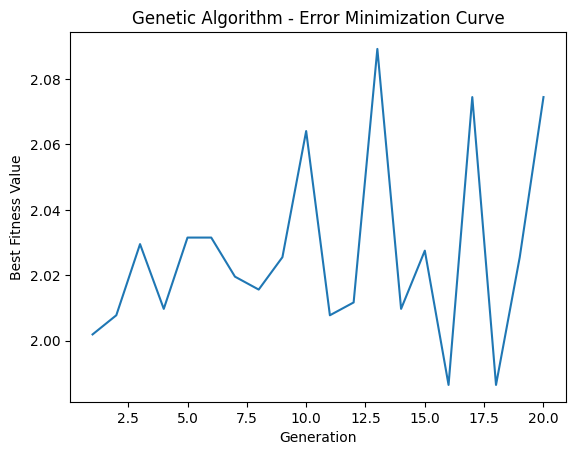

10255
actualclose      1.458600e+02
Target           1.000000e+00
close            1.448700e+02
volume           6.314160e+07
open             1.456700e+02
high             1.466400e+02
low              1.437800e+02
200day           1.582839e+02
50day            1.447154e+02
dif              1.051730e+00
%K               8.116649e+01
%D               9.238313e+01
rsi              7.069986e+01
CCI              7.522401e+00
A/D              4.431048e+10
udl              1.592115e+11
fsl             -1.370172e+08
Tenkan-sen       1.406600e+02
Kijun-sen        1.401550e+02
Senkou Span A    1.458600e+02
Senkou Span B    1.561100e+02
TR               3.259995e+00
ADX              2.094242e+01
Name: 2022-07-12 00:00:00, dtype: float64


In [ ]:
    # Plot the error minimization curve

import random
from datetime import datetime, timedelta

plt.plot(range(1, (20) + 1), losses)
plt.title('Genetic Algorithm - Error Minimization Curve')
plt.xlabel('Generation')
plt.ylabel('Best Fitness Value')
plt.show()

def rand_date():
# Define the range of dates
  start_date = datetime(2022, 1, 1)
  end_date = datetime(2023, 1, 1)

  random_number = random.randint(10000, 12000)
  print(random_number)
  print(processed_data.iloc[random_number])
rand_date()
  #sma for a 200 period
